# Kaggle: Toxic Comment Classification Challenge

## Import library

In [5]:
!python3 -m pip install pandas

    100% |################################| 8.7MB 168kB/s ta 0:00:01
    100% |################################| 512kB 1.3MB/s ta 0:00:01
You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!python3 -m pip install matplotlib

    100% |################################| 12.8MB 117kB/s ta 0:00:01
    100% |################################| 952kB 1.2MB/s ta 0:00:01
    100% |################################| 61kB 2.2MB/s ta 0:00:01
You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [99]:
import sys
import os
import re
import csv
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


## Read & Check train, test data

In [5]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
len(train)

159571

In [9]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [11]:
len(test)

153164

* check null

In [12]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [13]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

-> no null columns

* check the number/rate of toxic flag in test data set

In [14]:
train.loc[:, 'toxic':'identity_hate'].apply(sum)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [15]:
train.loc[:, 'toxic':'identity_hate'].apply(np.mean)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

-> very unbalanced data...

## Preprocessing

* split data set to X(explanation variable), y(objective variable)

In [16]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

* tokenize

In [17]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

-> no need to vectorise one-hot ? (proceeding with above data at first)

* check the number of token for each sentense (train data) & padding (setting upper limit of the number of tokens)

In [20]:
num_words = [len(x) for x in list_tokenized_train]

(array([1.42259e+05, 1.19490e+04, 2.68600e+03, 1.12100e+03, 8.62000e+02,
        5.55000e+02, 9.20000e+01, 3.10000e+01, 1.20000e+01, 4.00000e+00]),
 array([   0.,  140.,  280.,  420.,  560.,  700.,  840.,  980., 1120.,
        1260., 1400.]),
 <a list of 10 Patch objects>)

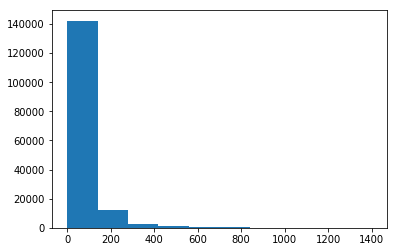

In [25]:
plt.hist(num_words)

(array([6.6717e+04, 3.9442e+04, 1.9385e+04, 1.0284e+04, 6.4310e+03,
        4.1910e+03, 3.0750e+03, 2.0940e+03, 1.4520e+03, 1.1370e+03,
        8.9900e+02, 6.1800e+02, 4.6000e+02, 3.8200e+02, 3.2700e+02,
        2.7200e+02, 2.4200e+02, 2.0400e+02, 2.0100e+02, 2.0200e+02,
        1.6700e+02, 1.7300e+02, 1.8900e+02, 1.6700e+02, 1.6600e+02,
        1.4400e+02, 1.2400e+02, 1.2500e+02, 9.8000e+01, 6.4000e+01,
        4.5000e+01, 2.1000e+01, 1.2000e+01, 9.0000e+00, 5.0000e+00,
        1.6000e+01, 3.0000e+00, 1.0000e+00, 6.0000e+00, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0.,   28.,   56.,   84.,  112.,  140.,  168.,  196.,  224.,
         252.,  280.,  308.,  336.,  364.,  392.,  420.,  448.,  476.,
         504.,  532.,  560.,  588.,  616.,  644.,  672.,  700.,  728.,
         756.,  784.,  812.,  840.,  868.,  896.,  924.,  952.,  980.,
        1008., 1036., 1064., 1092.

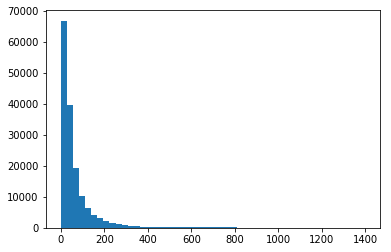

In [26]:
plt.hist(num_words, bins=50)

-> padding the number of tokens in a sentense @200

In [29]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Modeling (making network)

In [33]:
embed_size = 128
lstm_output_dim = 60
dense_output_dim = 50

inputs = Input(shape=(maxlen, )) 
x = Embedding(max_features, embed_size)(inputs)
x = LSTM(lstm_output_dim, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(dense_output_dim, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

## Learning

In [35]:
batch_size = 32
epochs = 2
model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1136s 8ms/step - loss: 0.0759 - acc: 0.9761 - val_loss: 0.0497 - val_acc: 0.9817
Epoch 2/2
143613/143613 [==============================] - 1014s 7ms/step - loss: 0.0461 - acc: 0.9827 - val_loss: 0.0470 - val_acc: 0.9824


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

* Summary about input & output dimension, the number of parameter of each layer

    * embedding: 20000dim -> 128dim (for 200 sqquence) (param=20000*128)

    * LSTM 128dim -> 60dim (input->output), 60dim -> 60dim(hidden->hidden) (for output, forget, input sigmoid, input tanh gate)(param=(128*60+60(bias) + 60*60)*4)

    * Full Connection layer(Activation: relu) 60dim -> 50dim (param=60*50+50)

    * Full Connecton layer(Activation: sigmoid) 50dim -> 6dim (param=50*6+6)

## Inference & make submit data

In [42]:
pred = model.predict(X_test)

In [90]:
#red_output = [[1 if x >= 0.5 else 0 for x in list] for list in pred ]
pred_output = pd.concat([test[['id']], pd.DataFrame(pred)], axis=1)
pred_output.columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pred_output.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997855,3.368382e-01,0.970427,4.936949e-02,0.873912,0.149853
1,0000247867823ef7,0.000948,5.617314e-07,0.000166,4.774788e-06,0.000117,0.000040
2,00013b17ad220c46,0.001582,2.762895e-06,0.000386,2.232697e-05,0.000292,0.000127
3,00017563c3f7919a,0.000688,9.471135e-08,0.000081,6.970980e-07,0.000054,0.000012
4,00017695ad8997eb,0.003372,3.499479e-06,0.000534,2.399500e-05,0.000496,0.000150


In [91]:
pred_output.to_csv('submit_data.csv', index=False)